In [1]:
# Import modules
import tensorflow as tf
#from tensorflow import keras
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Randomly generate some data
n = int(1e6)

lower, upper = 1.5e4, 5e4
mu, sigma = 3.0e4, 1e4
offer = stats.truncnorm((lower - mu) / sigma,
                        (upper - mu) / sigma,
                        loc=mu, scale=sigma).rvs(n)

lower, upper = 20, 32
mu, sigma = 25, 2
holiday = stats.truncnorm((lower - mu) / sigma,
                          (upper - mu) / sigma,
                          loc=mu, scale=sigma).rvs(n).astype(int)
holiday = holiday.astype(float)
holiday[holiday == 31] = np.inf

lower, upper = 0, 5,
mu, sigma = 2.5, 1
employees = (10**stats.truncnorm((lower - mu) / sigma,
                                 (upper - mu) / sigma,
                                 loc=mu, scale=sigma).rvs(n)).astype(int)

p = 1/4
hybrid = np.random.choice(a=[True, False], size=(n), p=[p, 1-p])

p = 1/4
remote = np.random.choice(a=[True, False], size=(n), p=[p, 1-p]) & hybrid

turnover = 1e4 * employees**0.5 * 10**np.random.normal(1, 0.2, n)

In [3]:
# Normalise data
def normalise(A, a=None):
    if a is None: a = A
    return (a - np.min(A))/np.ptp(A)

offer_n = normalise(np.log(offer))
holiday_n = 1 - np.exp(1 - holiday/20)
employees_n = normalise(1/(1+np.log(employees)) + np.log(employees)/10)
turnover_n = normalise(np.log(turnover))
hybrid_n = hybrid.astype(int)
remote_n = remote.astype(int)

In [4]:
# Function for probability of acceptance
def acceptance_probability(variables, weights, power=1):
    p = (variables.T * weights).sum(axis=1)
    p = p**power
    p[p>1] = 1
    return p

# Generate acceptance probabilities
variables =           np.array([offer_n, holiday_n, employees_n, turnover_n, hybrid_n, remote_n])
weights   = normalise(np.array([9,       6,         4,           2,          3,        4]))*0.85
acceptance = acceptance_probability(variables, weights, power=1)

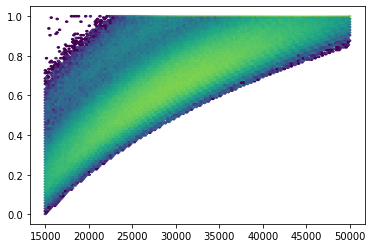

In [5]:
#i = np.random.randint(n)
#print('Offer:\t\t\t\t{:.2f}'.format(offer[i]))
#print('Holiday:\t\t\t{}'.format(holiday[i]))
#print('Turnover:\t\t\t{:.2f}'.format(turnover[i]))
#print('Remote?\t\t\t\t{:}'.format(hybrid[i]))
#print('Hybrid?\t\t\t\t{:}'.format(remote[i]))
#print('\nProbability of acceptance:\t{:0.0f}%'.format(acceptance[i]*100))
#plt.hist(acceptance, bins=100)
plt.hexbin(offer, acceptance, gridsize=128, mincnt=1, bins='log')
#plt.plot(np.log10(employees), acceptance, 'k.')
#plt.hexbin(employees, acceptance, gridsize=128, mincnt=1, xscale='log', bins='log')

In [6]:
# Decide if accepted or rejected
accepted = np.where(np.random.uniform(size=n) < acceptance, True, False)
accepted.mean()

0.691005

In [7]:
#from tensorflow.keras import datasets, layers, models

X = variables.T
y = accepted.astype(int)

# Build
model = tf.keras.Sequential([tf.keras.layers.Dense(12, input_shape=(X.shape[1],), activation='relu'),
                             tf.keras.layers.Dense(9, activation='relu'),
                             tf.keras.layers.Dense(4, activation='relu'),
                             tf.keras.layers.Dense(1, activation='sigmoid'),
                             ])

# Compile
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

#train
history = model.fit(X, y, verbose = 0,
                    validation_split = 0.5,
                    epochs=10, 
                    batch_size = 1024)

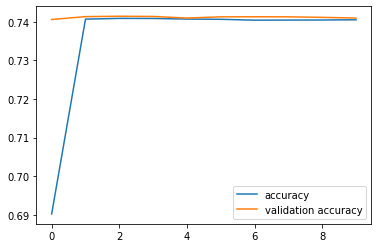

In [8]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['accuracy','validation accuracy'])

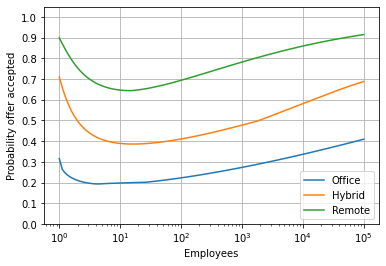

In [9]:
i = 101

o = np.array([25000]*i)
h = np.array([20]*i)

o_n = normalise(offer, o)
h_n = 1 - np.exp(1 - h/20)

e = np.logspace(0,5,i)
t = 1e4 * e**0.5
e_n = normalise(1/(1+np.log(employees)) + np.log(employees)/10, 1/(1+np.log(e)) + np.log(e)/10)
t_n = normalise(np.log(turnover), np.log(t))


office = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([0]*i), np.array([0]*i)]).T)
hybrid = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([1]*i), np.array([0]*i)]).T)
remote = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([1]*i), np.array([1]*i)]).T)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogx(e, office, label='Office')
ax.semilogx(e, hybrid, label='Hybrid')
ax.semilogx(e, remote, label='Remote')
ax.set_ylim([0, 1.05])
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlabel('Employees')
ax.set_ylabel('Probability offer accepted')
ax.grid()
ax.legend()

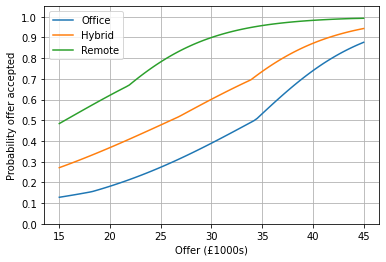

In [10]:
i = 101

h = np.array([20]*i)
e = np.array([1000]*i)
t = 1e4 * e**0.5
h_n = 1 - np.exp(1 - h/20)
e_n = normalise(1/(1+np.log(employees)) + np.log(employees)/10, 1/(1+np.log(e)) + np.log(e)/10)
t_n = normalise(np.log(turnover), np.log(t))


o = np.linspace(15000,45000,i)
o_n = normalise(offer, o)

office = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([0]*i), np.array([0]*i)]).T)
hybrid = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([1]*i), np.array([0]*i)]).T)
remote = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([1]*i), np.array([1]*i)]).T)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(o/1e3, office, label='Office')
ax.plot(o/1e3, hybrid, label='Hybrid')
ax.plot(o/1e3, remote, label='Remote')
ax.set_ylim([0, 1.05])
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xlabel('Offer (£1000s)')
ax.set_ylabel('Probability offer accepted')
ax.grid()
ax.legend()

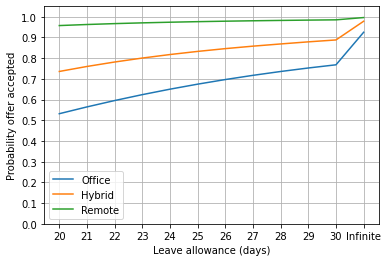

In [11]:
i = 12
o = np.array([35000]*i)
e = np.array([1000]*i)
t = 1e4 * e**0.5
o_n = normalise(offer, o)
e_n = normalise(1/(1+np.log(employees)) + np.log(employees)/10, 1/(1+np.log(e)) + np.log(e)/10)
t_n = normalise(np.log(turnover), np.log(t))

H = np.linspace(20,31,i)
h = np.linspace(20,31,i)
h[h == 31] = np.inf
h_n = 1 - np.exp(1 - h/20)


office = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([0]*i), np.array([0]*i)]).T)
hybrid = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([1]*i), np.array([0]*i)]).T)
remote = model.predict(np.array([o_n, h_n, e_n, t_n, np.array([1]*i), np.array([1]*i)]).T)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(H, office, label='Office')
ax.plot(H, hybrid, label='Hybrid')
ax.plot(H, remote, label='Remote')
ax.set_ylim([0, 1.05])
ax.set_yticks(np.linspace(0, 1, 11))
ax.set_xticks(H)
xticklabels = H.astype(int).astype(str)
xticklabels[-1] = "Infinite"
ax.set_xticklabels(xticklabels)
ax.set_xlabel('Leave allowance (days)')
ax.set_ylabel('Probability offer accepted')
ax.grid()
ax.legend()

In [12]:
_, accuracy = model.evaluate(X, accepted)
print(f'The model accuracy is {accuracy * 100:0.1f}%')

31250/31250 [==============================] - 123s 4ms/step - loss: 0.5049 - accuracy: 0.7404
The model accuracy is 74.0%
